In [1]:
import pandas as pd
import numpy as np
import requests
import time

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud

pd.set_option('max_columns', 85)

# Get Data

[Return to Table of Contents](#Contents:)

In [2]:
# GET COUNTRIES
country_names = [c_name for c_name in pd.read_csv('./data/country_names.csv')['name']]
# SOURCES: http://worldpopulationreview.com/countries/most-visited-countries/
    # & https://www.travel-advisory.info/api

In [3]:
url_api_base = 'https://api.pushshift.io'
url_comment = '/reddit/search/comment'
url_submission = '/reddit/search/submission'

In [4]:
travel_subreddits = ['shoestring', 'travel', 'wanderlust', 'solotravel', 'backpacking', 'campingandhiking',
                     'adventures', 'remoteplaces', 'longtermtravel', 'digitalnomad']


# Source: https://www.travelingmitch.com/mostrecent/travel-subreddits-tour-the-world

In [5]:
dfs = []

for c in country_names:
    params = {
        'subreddit': travel_subreddits,
        'q' : c, 
        'before': '90d',
        'after':'365d',
        'size':1000,
        'is_self' : 'true',
    }
    res = requests.get(url_api_base+url_submission, params)
    df_res = pd.DataFrame(res.json()['data'])
    df_res['country'] = c
    dfs.append(df_res)

df_travel = pd.concat(dfs, sort=True)
df_travel.shape

(33430, 83)

In [6]:
df_travel['selftext'].iloc[2050]

"Hello all!\n\nWe're very excited to announce that Alex, the badass solo traveling woman behind [Lost with Purpose](https://www.lostwithpurpose.com/) will be joining us on Saturday, May 18 for an AMA!\n\nHere's an introduction from Alex:\n\n---\n\n\nHey y'all! I'm Alex, a 28-year-old American solo female traveler and the creative brain behind Lost With Purpose travel blog [(lostwithpurpose.com)] (www.lostwithpurpose.com).\n\nFor the last three-ish years I've been backpacking full time, often roaming through countries people warned me to be well wary of such as Pakistan, Afghanistan, and Iran. People often think I'm either A) crazy or B) a member of ISIS but I assure you only A is true.\n\nIn the last three years I traveled through: Georgia, Armenia, Iran, Pakistan, China, Kazakhstan, Kyrgyzstan, Uzbekistan, Afghanistan, India, Nepal, Bhutan, and Bangladesh. The whole world calls to me, but I have a special place in my heart (and passport) for South Asia, particularly India and Pakistan

In [7]:
df_travel['subreddit'].value_counts()

travel              14669
solotravel          13519
backpacking          2609
digitalnomad         1176
Shoestring           1040
CampingandHiking      219
longtermtravel        107
wanderlust             50
adventures             35
remoteplaces            6
Name: subreddit, dtype: int64

In [8]:

dfs2 = []
for c in country_names:
    params_sub = {
        'subreddit' : c, 
        'q' : 'travel',
        'before': f'90d',
        'after':f'365d',
        'size':1000,
        'is_self' : 'true',
    }
    
    res = requests.get(url_api_base+url_submission, params_sub)
    df_res = pd.DataFrame(res.json()['data'])
    df_res['country'] = c
    dfs2.append(df_res)
    
    time.sleep(1)

df_country_subreddits = pd.concat(dfs2, sort=True)
df_country_subreddits.shape

(5826, 83)

In [9]:
df_country_subreddits['selftext'].iloc[3000]

'Hi! I am traveling to Italy in October for a wedding in Ravello. I fly in and out of Naples. After the wedding I have 8 days to travel. I will be renting a car and doing a roadtrip, and am looking for recommendations for towns to visit. I am open to all suggestions but am less interested in the touristy areas.\n\nAlso, I am wondering if it is difficult to rent a care and travel to islands. If I wanted to go to Capri, should I wait until after that to rent a car?'

In [10]:
df_country_subreddits['subreddit'].value_counts()

india            528
Philippines      421
canada           244
germany          235
VietNam          210
                ... 
Paraguay           1
Angola             1
Benin              1
Rwanda             1
liechtenstein      1
Name: subreddit, Length: 125, dtype: int64

# Preprocessing

[Return to Table of Contents](#Contents:)

In [11]:
important_cols = ['country', 'subreddit', 'selftext', 'title', 'subreddit_subscribers']
df_travel = df_travel[important_cols].copy()
df_country_subreddits = df_country_subreddits[important_cols].copy()
df = pd.concat([df_travel, df_country_subreddits], ignore_index=True)
df.shape

(39256, 5)

In [12]:
df = df[df['selftext']!='[removed]'].copy()
df = df[df['selftext']!='[deleted]'].copy()

df.shape

(31582, 5)

In [13]:
df['all_words'] = df['title'] + '  ' + df['selftext']
df['all_words'].tail()

39251    Is there any way for me to get a travel card s...
39252    How to travel to Dubai?  Does anyone know how ...
39253    How to renew passport in Sana'a  I am sorry th...
39254    I recently visited and didn't manage to bring ...
39255    I am a medical student from the US and will be...
Name: all_words, dtype: object

In [14]:
df.head()
# df[['country', 'subreddit', 'selftext', 'title', 'subreddit_subscribers']].head(7)

,country,subreddit,selftext,title,subreddit_subscribers,all_words
0,Andorra,solotravel,TLDR: one week trip to Barcelona in September....,"Booked my next trip, $411 RT from PHL to Barce...",530740.0,"Booked my next trip, $411 RT from PHL to Barce..."
1,Andorra,solotravel,Hello.\n\n&amp;#x200B;\n\nI was born and live ...,Find my country by criteria,541638.0,Find my country by criteria Hello.\n\n&amp;#x...
2,Andorra,travel,"**179 countries are eligible for E-VISA, aroun...","After the successful trial with 5 countries, P...",2619362.0,"After the successful trial with 5 countries, P..."
3,Andorra,solotravel,21m from Aus gonna be traveling Europe January...,Europe in winter tips,568773.0,Europe in winter tips 21m from Aus gonna be t...
4,Andorra,digitalnomad,"Hey there,\n\nAbout to become nomad, traveling...",Ideal tax setup for a European Nomad traveling...,456062.0,Ideal tax setup for a European Nomad traveling...


In [15]:
df.isnull().sum()

country                   0
subreddit                 0
selftext                 14
title                     0
subreddit_subscribers     0
all_words                14
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.shape

(31568, 6)

In [18]:
df.to_csv('./data/subreddits.csv', index=False)

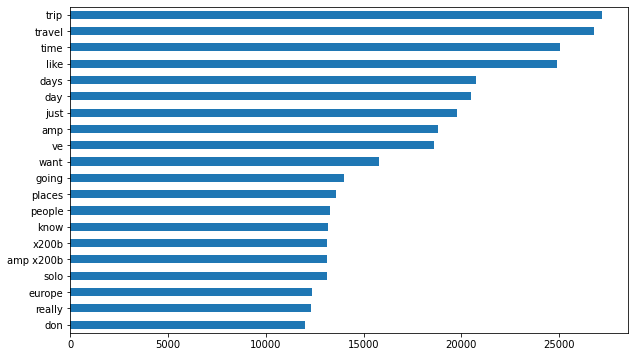

In [20]:
# Visualization of Word Frequency across all subreddits

cv = CountVectorizer(max_df=.9,
                     stop_words=ENGLISH_STOP_WORDS,
                     max_features= 700,
                     ngram_range= (1,3))

df_X_cv_nostop = pd.DataFrame(cv.fit_transform(df['all_words']).todense(),
              columns=cv.get_feature_names())

fig , ax = plt.subplots(figsize=(10,6))

df_X_cv_nostop.sum().sort_values().tail(20).plot.barh();